In [1]:
import numpy as np
import numpy.random as npr
npr.seed(0)
import matplotlib.pyplot as plt
%matplotlib inline

In [51]:
def skewed_gaussian_potential(x, eps=0.01):
    return (x[0] - x[1])**2/(2*eps) + ((x[0] + x[1])**2/(2))

separation = 0.5
true_free_energy_difference = 1.0
#def mixture_potential(x):
#    if (x[1] < x[0]):
#        return skewed_gaussian_potential(x-(separation,-separation))
#    else:
#        return elevation * skewed_gaussian_potential(x+(separation,-separation))
    
#def mixture(x):
#    return np.exp(-mixture_potential(x))

def mixture(x):
    return (x[1] < x[0]) * np.exp(-skewed_gaussian_potential(x-(separation,-separation))) + (x[1] > x[0]) * np.exp(true_free_energy_difference-skewed_gaussian_potential(x+(separation,-separation)))

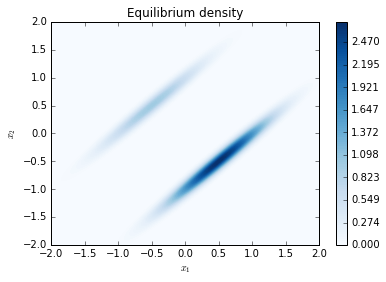

In [40]:
#x_ = np.random.rand(100000,2)*4 - 2
#plt.scatter(x_[:,0],x_[:,1],c=[mixture(point) for point in x_],s=2,linewidths=0,cmap='Blues')

n_grid = 300
linspace = np.linspace(-2,2,n_grid)
X = np.zeros((n_grid, n_grid))
for i in range(n_grid):
    for j in range(n_grid):
        X[i,j] = mixture(np.array([linspace[i], linspace[j]]))
        #X[i,j] = mixture_potential(np.array([linspace[i], linspace[j]]))
        

plt.contourf(linspace, linspace, X, levels=np.linspace(np.min(X),np.max(X),100), cmap='Blues')
plt.colorbar()
plt.xlim(-2,2)
plt.ylim(-2,2)
#plt.axis('off')
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.title('Equilibrium density')

In [42]:
def metropolis_hastings(x0, q, n_samples=100, step_size=0.05):
    ndim = len(x0)
    q0 = q(x0)
    samples = np.zeros((n_samples,ndim))
    for i in range(n_samples):
        x1 = x0 + npr.randn(ndim)*step_size
        q1 = q(x1)
        if npr.rand() <= q1 / q0:
            samples[i] = x1
            x0 = x1
            q0 = q1
        else:
            samples[i] = x0
    
    return samples

In [43]:
npr.seed(0)
x = metropolis_hastings(np.array((1,-1)),mixture,100000)
y = metropolis_hastings(np.array((-1,1)),mixture,100000)

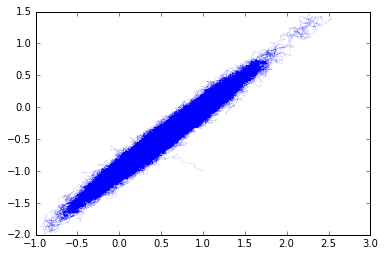

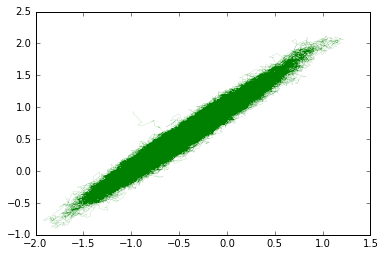

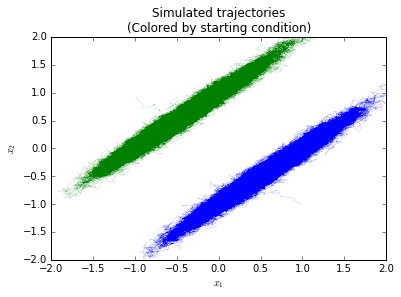

In [44]:
plt.plot(x[:,0], x[:,1],linewidth=0.1, color='blue')
plt.figure()
plt.plot(y[:,0], y[:,1],linewidth=0.1, color='green')

plt.figure()
plt.plot(x[:,0], x[:,1],linewidth=0.1)
plt.plot(y[:,0], y[:,1],linewidth=0.1)
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.xlim(-2,2)
plt.ylim(-2,2)
plt.title('Simulated trajectories\n(Colored by starting condition)')

In [45]:
u_kln = np.zeros((2, 2, len(x)))
u_kln[0][0] = np.array([mixture(x_) for x_ in x])
u_kln[0][1] = np.array([mixture(x_) for x_ in y])
u_kln[1][0] = np.array([mixture(x_) for x_ in x])
u_kln[1][1] = np.array([mixture(x_) for x_ in y])

N_k = np.array((len(x), len(y)))

In [46]:
# let's evaluate the free energy difference using MBAR
from pymbar import MBAR
mbar = MBAR(u_kln, N_k)

In [47]:
mbar.f_k

array([ 0.        ,  0.90128278])

In [48]:
X = np.vstack((x,y))
X.shape

(200000, 2)

In [49]:
import pyemma

In [141]:
#kmeans = pyemma.coordinates.cluster_mini_batch_kmeans([x,y],k=10,max_iter=10)
regtime = pyemma.coordinates.cluster_uniform_time([x,y], k=10)

08-09-16 09:07:13 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[8] INFO     Algorithm did not reach convergence criterion of 1e-05 in 10 iterations. Consider increasing max_iter.


In [134]:
#dtrajs = [dtraj.flatten() for dtraj in kmeans.get_output()]

In [142]:
dtrajs = [dtraj.flatten() for dtraj in regtime.get_output()]

In [143]:
dtrajs[0]

array([4, 4, 4, ..., 0, 0, 0], dtype=int32)

In [144]:
c = np.hstack(dtrajs)

In [145]:
len(X), len(c)

(200000, 200000)

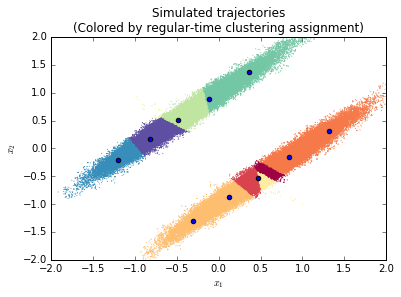

In [149]:
plt.scatter(X[:,0], X[:,1],linewidth=0,c=np.hstack(dtrajs),s=1,cmap='Spectral')
plt.scatter(kmeans.clustercenters[:,0], kmeans.clustercenters[:,1])
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.xlim(-2,2)
plt.ylim(-2,2)
plt.title('Simulated trajectories\n(Colored by regular-time clustering assignment)')

In [150]:
msm = pyemma.msm.estimate_markov_model(dtrajs,1)

/Users/joshuafass/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log


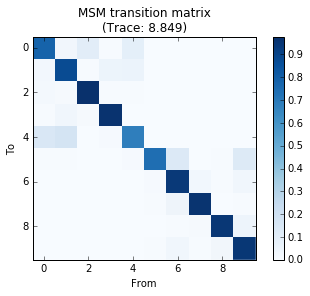

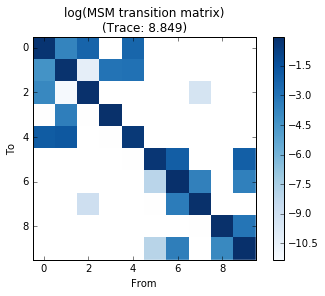

In [151]:
plt.imshow(msm.P,interpolation='none',cmap='Blues')
plt.title('MSM transition matrix\n(Trace: {0:.3f})'.format(np.trace(msm.P)))
plt.xlabel('From')
plt.ylabel('To')
plt.colorbar()

plt.figure()

plt.imshow(np.log(msm.P),interpolation='none',cmap='Blues')
plt.title('log(MSM transition matrix)\n(Trace: {0:.3f})'.format(np.trace(msm.P)))
plt.xlabel('From')
plt.ylabel('To')
plt.colorbar()

In [152]:
np.trace(msm.P)

8.8492080919352425

In [153]:
msm.active_count_fraction, msm.active_state_fraction

(1.0, 1.0)

In [154]:
lags = range(1,100)
its = pyemma.msm.its(dtrajs,lags,nits=5, errors='bayes')

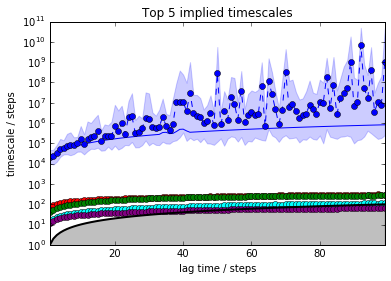

In [155]:
pyemma.plots.plot_implied_timescales(its)
plt.title('Top 5 implied timescales')

In [159]:
cktest = msm.cktest(2,mlags=100)

(<matplotlib.figure.Figure at 0x13d8b6fd0>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x126a93290>,
         <matplotlib.axes._subplots.AxesSubplot object at 0x13dade1d0>]], dtype=object))

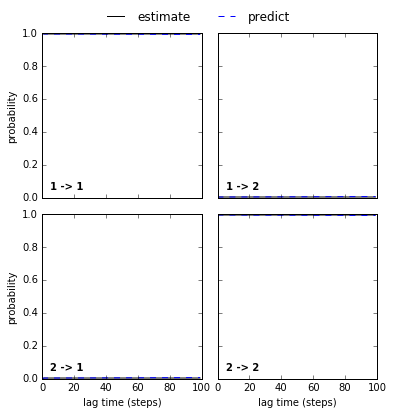

In [164]:
pyemma.plots.plot_cktest(cktest)


In [158]:
# what if we did tICA?

tica = pyemma.coordinates.tica([x,y])

In [67]:
tica.timescales

array([ 1292.68667956,   447.37288151])

In [68]:
tica.eigenvectors[0]

array([-0.9979056 ,  1.07551866])

In [69]:
X_tica = np.vstack(tica.get_output())
X_tica.shape

(200000, 2)

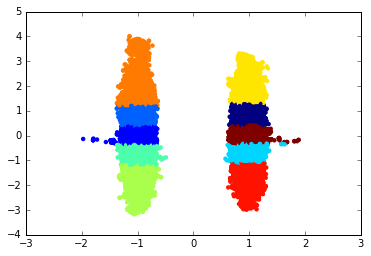

In [70]:
plt.scatter(X_tica[:,0], X_tica[:,1], c=c, linewidths=0)

In [71]:
kmeans = pyemma.coordinates.cluster_mini_batch_kmeans(tica.get_output(),k=20,max_iter=1000)

07-09-16 12:53:56 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[6] INFO     Cluster centers converged after 694 steps.


In [72]:
dtrajs = [dtraj.flatten() for dtraj in kmeans.get_output()]
msm = pyemma.msm.estimate_markov_model(dtrajs,1)

In [73]:
msm.active_count_fraction, msm.active_state_fraction

(0.5, 0.5)

In [74]:
np.trace(msm.P)

9.1960415563239124

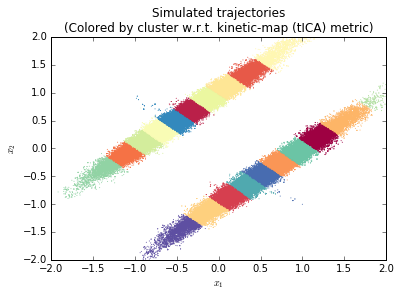

In [75]:
plt.scatter(X[:,0], X[:,1],linewidth=0,c=np.hstack(dtrajs),s=1,cmap='Spectral')
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.xlim(-2,2)
plt.ylim(-2,2)
plt.title('Simulated trajectories\n(Colored by cluster w.r.t. kinetic-map (tICA) metric)')

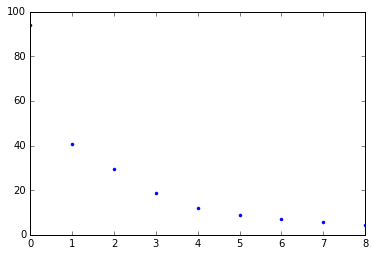

In [76]:
# what's the estimated relative free energy of the two macrostates / would we be able to identify two macrostates?

plt.plot(msm.timescales(),'.')

In [106]:
%%time
hmm = pyemma.msm.estimate_hidden_markov_model(dtrajs, 2, 1, maxit=1000)

CPU times: user 1.07 s, sys: 11.1 ms, total: 1.08 s
Wall time: 1.06 s


In [107]:
hmm.pi

array([ 0.30915457,  0.69084543])

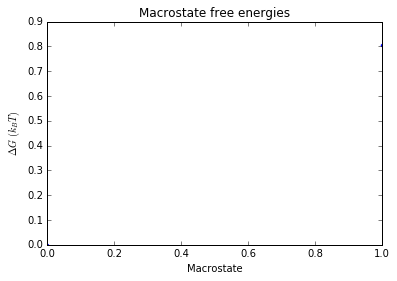

In [108]:
f_i = -np.log(sorted(hmm.stationary_distribution))[::-1]
f_i -= f_i.min()
plt.figure()
plt.plot(f_i, '.')
plt.xlabel('Macrostate')
plt.ylabel(r'$\Delta G$ $(k_B T)$')
plt.title('Macrostate free energies')

In [109]:
f_i

array([ 0.        ,  0.80407472])

In [110]:
hmm.observation_probabilities

array([[  1.56150695e-001,   1.35338811e-193,   9.61696182e-195,
          5.45121180e-194,   6.67286325e-194,   2.44843643e-001,
          7.62882267e-002,   4.41404462e-202,   8.81840095e-194,
          1.95828712e-194,   1.23669306e-193,   1.20921703e-193,
          1.81373801e-193,   8.57171087e-003,   2.87009201e-194,
          2.11058164e-001,   2.85271072e-002,   2.74103710e-193,
          2.74560453e-001,   9.28758667e-204],
       [  4.53150722e-236,   1.11320434e-001,   8.41941753e-002,
          4.42936777e-002,   5.44696435e-002,   6.83304555e-191,
          1.03337903e-236,   5.96372392e-002,   7.17239127e-002,
          1.59080888e-002,   1.01918884e-001,   9.86040956e-002,
          8.36296480e-002,   1.99369385e-238,   2.33410311e-002,
          4.50945787e-235,   1.06226169e-001,   1.18543488e-001,
          5.10760239e-004,   2.56787530e-002]])

In [111]:
# color by hidden state membership: red channel = state 0, blue channel = state 1
dtrajs_ = np.hstack(dtrajs)
rbg = np.zeros((len(dtrajs_), 3))

for i in range(len(dtrajs_)):
    p_0 = hmm.observation_probabilities[0][dtrajs_[i]]
    p_1 = hmm.observation_probabilities[1][dtrajs_[i]]
    rbg[i,0] = p_0 / (p_0 + p_1)
    rbg[i,2] = p_1 / (p_0 + p_1)
    
#rgb *= 255
#rgb = np.array(rgb, dtype=int)
#rgb[:10]

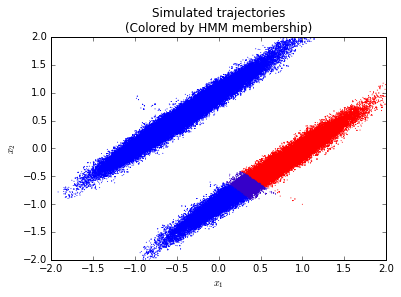

In [112]:
plt.scatter(X[:,0], X[:,1],linewidth=0,c=rbg,s=1)#,cmap='Spectral')
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.xlim(-2,2)
plt.ylim(-2,2)
plt.title('Simulated trajectories\n(Colored by HMM membership)')

In [113]:
trajs = [x,y]

In [130]:
npr.seed(100)
sample_inds = hmm.sample_by_observation_probabilities(10)

In [131]:
samples = [np.array([trajs[i][j] for (i,j) in state]) for state in sample_inds]

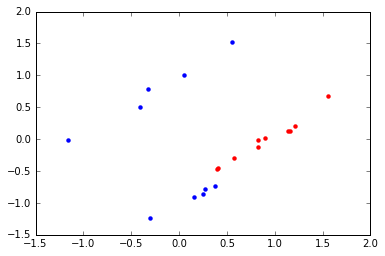

In [132]:
plt.scatter(samples[0][:,0], samples[0][:,1], linewidths=0, c='red')
plt.scatter(samples[1][:,0], samples[1][:,1], linewidths=0, c='blue')

So, in this case, we'd take samples from the red region and assume there's a free energy penalty of ~0.8 to confine there relative to , when in 